In [26]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [28]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [29]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [30]:
tf.keras.backend.clear_session()

In [31]:
subject = 'São Paulo - Consumo de Cimento (t)'
start_index = 0
split_index = 203
window_size = 36
train_split = split_index + 1 - 12

In [32]:
data = pd.read_csv('2003_mo_model_input_SP.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,São Paulo- custo m2 (R$),São Paulo - IDH Longevidade,São Paulo - IDH Renda,São Paulo - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - IDH Educacao,São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,12606.426400,0.835043,0.825444,782.111,1.249379,836.486933,1254.225718,13.470493,11.219632,87.918957,1.587388,437.972720,0.794676,8.652299e+07,0.314974,1.034903e+09,4.730940e+07,23.895559,9.819129e+08,8.310335,0.812723,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,12718.304862,0.835425,0.825117,789.891,1.114976,836.981236,1268.256958,13.555238,10.140963,82.539126,1.957841,434.363720,0.794957,8.659168e+07,0.317328,1.036092e+09,4.732994e+07,23.901472,9.822666e+08,8.304194,0.812838,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,12824.573380,0.835806,0.824790,774.309,0.946194,837.344257,1270.950707,13.460122,9.537375,80.042714,2.068918,433.350868,0.795239,8.666036e+07,0.319840,1.037280e+09,4.735047e+07,23.907385,9.826203e+08,8.298053,0.812953,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,12924.495880,0.836188,0.824463,782.071,0.857395,837.859987,1261.707476,13.181964,8.663709,77.171627,2.177406,431.825332,0.795521,8.672905e+07,0.322104,1.038469e+09,4.737101e+07,23.913298,9.829741e+08,8.291912,0.813068,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,13031.542087,0.836570,0.824137,841.400,0.688185,838.094744,1264.729439,12.670356,7.872689,75.721222,2.092594,433.287298,0.795802,8.679773e+07,0.324320,1.039658e+09,4.739155e+07,23.919210,9.833278e+08,8.285771,0.813183,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39560.290067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,39516.207562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,39457.198332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,39382.246174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


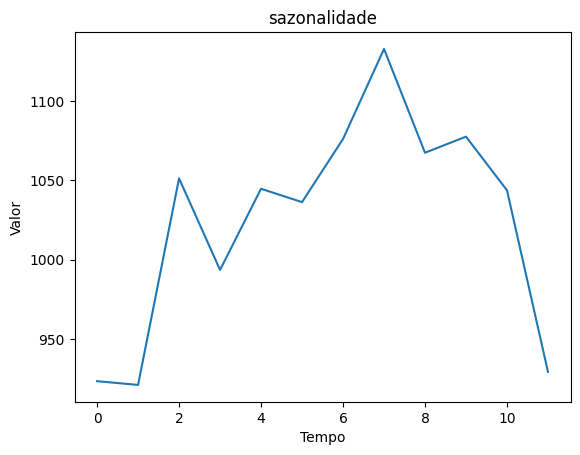

,sazonalidade
sazonalidade,
0,923.301429
1,920.936457
2,1051.293388
3,993.534145
4,1044.744126
5,1036.303327
6,1076.166614
7,1132.994081
8,1067.486946


In [33]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [34]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,São Paulo- custo m2 (R$),São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - IDH Educacao,São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Per Capita,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,São Paulo - IDH,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,São Paulo - Consumo de Cimento (t)
0,2003-1,12606.426400,0.835043,0.825444,1.249379,836.486933,1254.225718,13.470493,11.219632,87.918957,1.587388,437.972720,0.794676,8.652299e+07,0.314974,1.034903e+09,4.730940e+07,23.895559,9.819129e+08,8.310335,0.812723,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,923.301429,782.111
1,2003-2,12718.304862,0.835425,0.825117,1.114976,836.981236,1268.256958,13.555238,10.140963,82.539126,1.957841,434.363720,0.794957,8.659168e+07,0.317328,1.036092e+09,4.732994e+07,23.901472,9.822666e+08,8.304194,0.812838,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,920.936457,789.891
2,2003-3,12824.573380,0.835806,0.824790,0.946194,837.344257,1270.950707,13.460122,9.537375,80.042714,2.068918,433.350868,0.795239,8.666036e+07,0.319840,1.037280e+09,4.735047e+07,23.907385,9.826203e+08,8.298053,0.812953,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,1051.293388,774.309
3,2003-4,12924.495880,0.836188,0.824463,0.857395,837.859987,1261.707476,13.181964,8.663709,77.171627,2.177406,431.825332,0.795521,8.672905e+07,0.322104,1.038469e+09,4.737101e+07,23.913298,9.829741e+08,8.291912,0.813068,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,993.534145,782.071
4,2003-5,13031.542087,0.836570,0.824137,0.688185,838.094744,1264.729439,12.670356,7.872689,75.721222,2.092594,433.287298,0.795802,8.679773e+07,0.324320,1.039658e+09,4.739155e+07,23.919210,9.833278e+08,8.285771,0.813183,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,1044.744126,841.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39560.290067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1044.744126,NaN
245,2023-6,39516.207562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1036.303327,NaN
246,2023-7,39457.198332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1076.166614,NaN
247,2023-8,39382.246174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1132.994081,NaN


In [35]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      656.269
1      745.154
2      788.618
3      790.169
4      791.663
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: São Paulo - Consumo de Cimento (t), Length: 249, dtype: float64

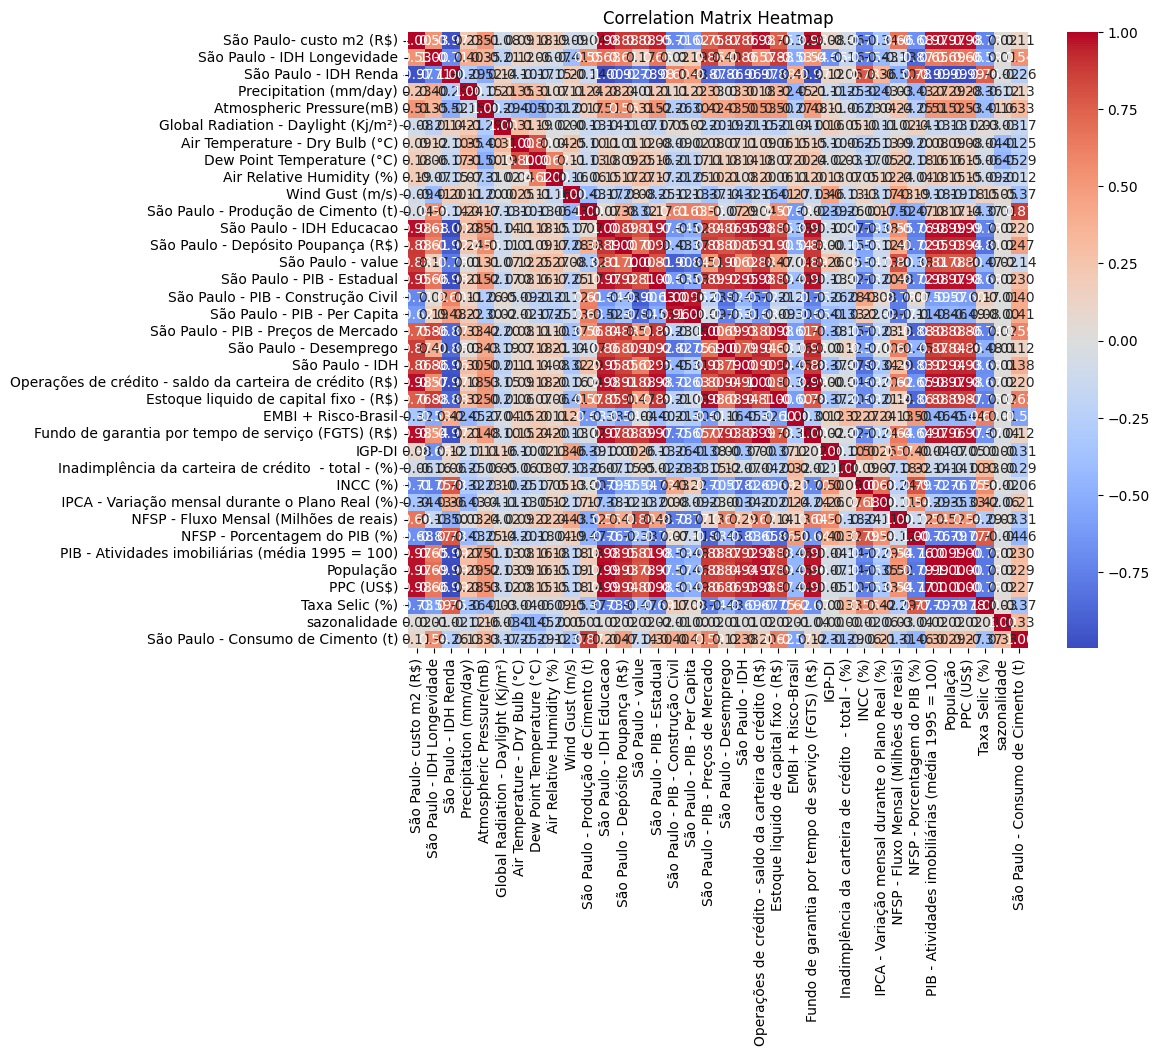

In [36]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [38]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,São Paulo- custo m2 (R$),6.047284e+04
1,São Paulo - IDH Longevidade,8.397906e+03
2,São Paulo - IDH Renda,6.665080e+07
3,Precipitation (mm/day),3.584372e+00
4,Atmospheric Pressure(mB),1.484277e+01
5,Global Radiation - Daylight (Kj/m²),3.096707e+00
6,Air Temperature - Dry Bulb (°C),3.551118e+02
7,Dew Point Temperature (°C),6.028744e+02
8,Air Relative Humidity (%),2.435891e+02
9,Wind Gust (m/s),1.143607e+01


In [39]:
data =data.drop(['Precipitation (mm/day)',
                 'Global Radiation - Daylight (Kj/m²)',
                 'Air Temperature - Dry Bulb (°C)',
                 'Dew Point Temperature (°C)', 
                 'Air Relative Humidity (%)'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 3


,São Paulo- custo m2 (R$),São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - IDH Educacao,São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,12606.426400,0.835043,0.825444,1.249379,836.486933,1254.225718,13.470493,11.219632,87.918957,1.587388,437.972720,0.794676,8.652299e+07,0.314974,1.034903e+09,4.730940e+07,9.819129e+08,8.310335,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,923.301429
1,12718.304862,0.835425,0.825117,1.114976,836.981236,1268.256958,13.555238,10.140963,82.539126,1.957841,434.363720,0.794957,8.659168e+07,0.317328,1.036092e+09,4.732994e+07,9.822666e+08,8.304194,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,920.936457
2,12824.573380,0.835806,0.824790,0.946194,837.344257,1270.950707,13.460122,9.537375,80.042714,2.068918,433.350868,0.795239,8.666036e+07,0.319840,1.037280e+09,4.735047e+07,9.826203e+08,8.298053,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,1051.293388
3,12924.495880,0.836188,0.824463,0.857395,837.859987,1261.707476,13.181964,8.663709,77.171627,2.177406,431.825332,0.795521,8.672905e+07,0.322104,1.038469e+09,4.737101e+07,9.829741e+08,8.291912,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,993.534145
4,13031.542087,0.836570,0.824137,0.688185,838.094744,1264.729439,12.670356,7.872689,75.721222,2.092594,433.287298,0.795802,8.679773e+07,0.324320,1.039658e+09,4.739155e+07,9.833278e+08,8.285771,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,1044.744126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,30452.293569,0.846104,0.785153,1.327534,837.721152,1291.599857,14.752888,11.351353,82.548812,2.973206,486.734307,0.831482,1.651505e+08,0.439146,1.196422e+09,4.647279e+07,9.979127e+08,11.108812,3.339533e+06,256.861070,1.038665e+07,1.139835,3.035443,0.628071,0.411247,6518.883661,1.836884,207.092470,2.005841e+08,437.906135,0.516394,1132.994081
200,30676.947227,0.845731,0.785111,1.432074,836.928401,1306.776589,15.597842,12.375573,83.267520,2.845851,488.920003,0.831356,1.672356e+08,0.442065,1.195231e+09,4.648906e+07,9.977236e+08,11.095946,3.365687e+06,257.536049,1.036684e+07,1.152658,3.032326,0.635009,0.433581,6534.198970,1.814025,207.285636,2.006695e+08,438.554287,0.509923,1067.486946
201,30913.859859,0.845357,0.785069,1.452408,836.195286,1308.602194,16.157961,13.347657,84.756594,2.704356,491.987979,0.831230,1.693206e+08,0.445223,1.194040e+09,4.650533e+07,9.975345e+08,11.083080,3.396904e+06,259.995111,1.094126e+07,1.188899,3.007554,0.648424,0.461431,6135.626515,1.810325,207.478801,2.007550e+08,439.156241,0.467083,1077.628993
202,31161.152576,0.844984,0.785027,1.568945,835.833300,1245.256920,16.487561,14.300765,87.105272,2.551532,492.990882,0.831104,1.714057e+08,0.448422,1.192849e+09,4.652160e+07,9.973453e+08,11.070213,3.

In [40]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - IDH Educacao,São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,-3.004419,2.017339,-0.345932,0.109612,0.502293,-1.348284,-0.271467,1.216867,-0.228796,-1.346981,-1.943201,-1.546323,-1.192702,-1.781982,-0.331463,-2.828491,-0.864232,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141
1,-2.928911,1.991176,-0.809090,0.479594,0.617072,-1.281104,-0.906647,0.166237,0.314781,-1.377134,-1.918815,-1.543723,-1.131195,-1.762455,-0.307767,-2.763218,-0.868102,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904
2,-2.853404,1.965014,-1.390722,0.751313,0.639107,-1.356505,-1.262072,-0.321289,0.477767,-1.385597,-1.894430,-1.541123,-1.065557,-1.742929,-0.284070,-2.697944,-0.871972,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828
3,-2.777896,1.938851,-1.696730,1.137335,0.563496,-1.577009,-1.776534,-0.881986,0.636955,-1.398342,-1.870045,-1.538522,-1.006384,-1.723402,-0.260374,-2.632671,-0.875841,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354
4,-2.702389,1.912689,-2.279838,1.313049,0.588216,-1.982577,-2.242330,-1.165236,0.512508,-1.386128,-1.845660,-1.535922,-0.948490,-1.703875,-0.236678,-2.567398,-0.879711,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,-0.816735,-1.207938,-0.076604,1.033418,0.808021,-0.331690,-0.193903,0.168128,1.804656,-0.939583,1.243592,1.430312,2.052031,0.871127,-1.296811,0.123896,0.899140,1.360064,-0.334258,1.332879,3.148408,-0.736097,0.370628,-0.689886,2.909383,-0.724085,1.428371,1.378950,1.402207,-1.370268
200,-0.890576,-1.211305,0.283648,0.440048,0.932170,0.338132,0.409214,0.308485,1.617785,-0.921321,1.232680,1.509248,2.128312,0.851567,-1.278038,0.089001,0.891033,1.384545,-0.327663,1.326386,3.219670,-0.746418,0.427775,-0.441954,2.913017,-0.736434,1.436331,1.391539,1.410056,-1.390925
201,-0.964416,-1.214672,0.353720,-0.108685,0.947103,0.782155,0.981630,0.599287,1.410164,-0.895689,1.221769,1.588183,2.210823,0.832007,-1.259265,0.054105,0.882926,1.413764,-0.303635,1.514665,3.421082,-0.828457,0.538287,-0.132782,2.818435,-0.738433,1.444292,1.404128,1.417346,-1.527663
202,-1.038257,-1.218040,0.755313,-0.379629,0.428927,1.043439,1.542872,1.057962,1.185921,-0.887309,1.210857,1.667118,2.294419,0.812447,-1.240492,0.019209,0.874818,1.440408,-0.275803,1.747673,3.373840,-0.866800,0.666156,0.084061,2.905726,-0.738236,1.456774,1.416717,1.423988,-1.609340


In [41]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - IDH Educacao,São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,-3.004419,2.017339,-0.345932,0.109612,0.502293,-1.348284,-0.271467,1.216867,-0.228796,-1.346981,-1.943201,-1.546323,-1.192702,-1.781982,-0.331463,-2.828491,-0.864232,-1.405679,-0.581961,-1.384242,2.574314,1.320402,3.184489,2.782450,0.097384,4.506880,-1.894583,-2.064648,-1.851489,2.125141
1,-2.928911,1.991176,-0.809090,0.479594,0.617072,-1.281104,-0.906647,0.166237,0.314781,-1.377134,-1.918815,-1.543723,-1.131195,-1.762455,-0.307767,-2.763218,-0.868102,-1.405133,-0.804750,-1.415865,2.334870,1.314693,3.029073,2.407943,0.100462,4.328460,-1.889555,-2.037913,-1.840236,1.610904
2,-2.853404,1.965014,-1.390722,0.751313,0.639107,-1.356505,-1.262072,-0.321289,0.477767,-1.385597,-1.894430,-1.541123,-1.065557,-1.742929,-0.284070,-2.697944,-0.871972,-1.405096,-0.619149,-1.428073,2.221334,1.313266,2.926505,2.179073,0.072380,4.129086,-1.884527,-2.011179,-1.828623,2.950828
3,-2.777896,1.938851,-1.696730,1.137335,0.563496,-1.577009,-1.776534,-0.881986,0.636955,-1.398342,-1.870045,-1.538522,-1.006384,-1.723402,-0.260374,-2.632671,-0.875841,-1.404678,-0.126522,-1.431053,2.040542,1.311046,2.828220,2.077086,0.008167,3.911409,-1.879499,-1.984445,-1.816740,1.307354
4,-2.702389,1.912689,-2.279838,1.313049,0.588216,-1.982577,-2.242330,-1.165236,0.512508,-1.386128,-1.845660,-1.535922,-0.948490,-1.703875,-0.236678,-2.567398,-0.879711,-1.403356,0.525280,-1.424070,1.912744,1.300019,3.036493,1.942128,0.033724,3.663912,-1.873302,-1.957710,-1.805169,2.042281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.011116,-1.196728,-0.192055,0.447340,0.198296,-0.816620,-0.329283,0.613336,0.506670,-1.146212,1.309858,0.849394,1.415236,1.056020,-1.461204,0.438480,0.987506,1.193119,-0.234432,1.098595,0.237913,-0.637894,-1.790206,-1.972576,2.018327,-0.537386,1.267871,1.238976,1.279826,-1.152820
188,-0.051077,-1.194256,0.537962,0.047741,0.365707,-0.154792,0.270347,0.776604,1.207944,-1.128921,1.311881,0.855068,1.415781,1.046426,-1.454608,0.424418,0.981183,1.206925,-0.187714,1.076314,0.559735,-0.723145,-1.629944,-1.832285,2.313396,-0.553461,1.288480,1.249345,1.291262,-1.253503
189,-0.113270,-1.191783,0.682618,0.082328,0.429998,0.503764,0.868843,0.954720,1.774712,-1.115035,1.313904,0.860742,1.421088,1.036832,-1.448012,0.410355,0.974860,1.227934,-0.161779,1.263463,0.802696,-0.863773,-1.383366,-1.767518,2.353157,-0.577640,1.309088,1.259715,1.301919,-1.425444
190,-0.175464,-1.189311,1.423924,-0.008253,0.476630,0.951666,1.211541,0.983261,1.904999,-1.102771,1.315927,0.866416,1.431351,1.027237,-1.441416,0.396292,0.968537,1.246115,-0.157728,1.498990,1.106124,-0.975183,-1.227161,-1.688436,2.550824,-0.606406,1.322965,1.270085,1.311660,-1.237935


In [42]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       656.269
1       745.154
2       788.618
3       790.169
4       791.663
         ...   
187    1046.707
188    1037.790
189    1023.994
190     958.552
191     783.915
Name: São Paulo - Consumo de Cimento (t), Length: 192, dtype: float64

In [43]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [44]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(156, 36, 30)

In [45]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,São Paulo - IDH Longevidade,São Paulo - IDH Renda,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),São Paulo - Produção de Cimento (t),São Paulo - IDH Educacao,São Paulo - Depósito Poupança (R$),São Paulo - value,São Paulo - PIB - Estadual,São Paulo - PIB - Construção Civil,São Paulo - PIB - Preços de Mercado,São Paulo - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
156,1.533841,-1.222798,0.764048,0.148598,-0.461118,1.632674,2.054336,0.933824,0.305122,-0.487896,1.290924,0.280883,0.784424,1.140474,-1.254119,0.749899,1.381593,1.222613,0.893819,1.318837,-0.878779,0.613775,-0.843949,0.077835,0.557789,-0.555830,0.827975,0.903734,0.911463,0.407265
157,1.493370,-1.220998,0.684722,0.519436,-1.076355,1.168658,1.792333,0.940984,0.098354,-0.545790,1.287664,0.302845,0.798025,1.142383,-1.271852,0.744115,1.361232,1.211968,1.005776,1.195627,-1.051645,0.807648,-0.905729,-0.168265,0.729389,-0.572666,0.830073,0.914718,0.922870,0.137084
158,1.452900,-1.219199,0.627310,0.811513,-2.024867,0.256846,1.124254,0.880651,-0.092468,-0.590506,1.284403,0.324806,0.806805,1.144291,-1.289584,0.738332,1.340871,1.202030,1.076752,1.159056,-1.098564,1.037275,-0.974248,-0.389950,0.683989,-0.585674,0.832171,0.925702,0.935360,0.296087
159,1.412429,-1.217399,-0.329504,1.044712,-2.852243,-0.494959,0.231714,0.394184,-0.243431,-0.636820,1.281143,0.346768,0.820627,1.146199,-1.307317,0.732548,1.320511,1.192181,1.085553,1.111178,-1.062721,1.108728,-1.053570,-0.479719,0.610357,-0.596842,0.834269,0.936687,0.948135,0.197300
160,1.371958,-1.215600,-0.449094,1.203713,-3.470869,-1.225941,-0.450930,0.195926,-0.328924,-0.694956,1.277882,0.368730,0.830024,1.148108,-1.325049,0.726764,1.300150,1.183708,1.062918,1.101433,-0.935050,1.109333,-1.130350,-0.570527,0.678235,-0.605761,0.833606,0.947671,0.961143,0.469403
161,1.331487,-1.213800,-0.210766,1.234391,-2.914322,-1.330580,-0.844913,-0.208236,-0.439893,-0.722948,1.274622,0.390691,0.837904,1.150016,-1.342782,0.720981,1.279789,1.174004,1.000960,1.094619,-0.911738,1.064134,-1.002475,-0.507950,0.656325,-0.615263,0.832943,0.958655,0.973478,0.775434
162,1.291016,-1.212001,-0.400289,0.961703,-1.939165,-0.973567,-0.687593,-0.391665,-0.514530,-0.757718,1.271361,0.412653,0.850744,1.151924,-1.360514,0.715197,1.259428,1.166949,0.914197,1.070145,-1.067437,1.167813,-1.242922,-0.557480,0.601603,-0.618938,0.832280,0.969639,0.985778,0.136553
163,1.250545,-1.210202,0.261717,0.538659,-1.033310,-0.652345,-0.236420,-0.160397,-0.563958,-0.790071,1.268100,0.434614,0.865927,1.153832,-1.378247,0.709413,1.239068,1.159632,0.810555,1.060594,-0.970725,1.364965,-1.322806,-0.742853,0.615006,-0.619453,0.840249,0.980624,0.999021,0.642038
164,1.210074,-1.208402,0.367892,0.203638,0.246705,0.297347,0.342592,-0.318587,-0.591970,-0.816804,1.264840,0.456576,0.894440,1.155741,-1.395979,0.703630,1.218707,1.154709,0.652883,1.041994,-0.841670,1.531106,-1.355523,-0.787367,0.546355,-0.611176,0.848219,0.991608,1.012408,0.482412
165,1.169603,-1.206603,0.074245,-0.054546,1.506393,1.326904,1.016392,-0.457629,-0.619866,-0.843214,1.261579,0.478537,0.918170,1.157649,-1.413712,0.697846,1.198346,1.151483,0.494053,1.195016,-0.838453,1.617011,-1.376175,-0.757940,0.421319,-0.599627,0.856189,1.002592,1.025524,0.367764


In [46]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 30)

In [47]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(180, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2990542124, 2304827610, 3949418440, 1798191123, 2697853478, 3278322779, 2047107912, 3486059866, 1737786550, 4058053032]


Step: 0 ___________________________________________
val_loss: 10643.4453125
winner_seed: 2990542124


Step: 1 ___________________________________________
val_loss: 384650051584.0


Step: 2 ___________________________________________
val_loss: 10669.5224609375


Step: 3 ___________________________________________
val_loss: 10649.12890625


Step: 4 ___________________________________________
val_loss: 858544320.0


Step: 5 ___________________________________________
val_loss: 7.22877263936195e+25


Step: 6 ___________________________________________
val_loss: 10721.4384765625


Step: 7 ___________________________________________
val_loss: 10656.1025390625


Step: 8 ___________________________________________
val_loss: 2156678.25


Step: 9 ___________________________________________
val_loss: 10704.939453125


final_seed: 2990542124


In [51]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
5/5 [==============================] - 2s 86ms/step - loss: 661570.0625 - val_loss: 93949.6641
Epoch 2/10000
5/5 [==============================] - 0s 6ms/step - loss: 37107.6758 - val_loss: 36771.9688
Epoch 3/10000
5/5 [==============================] - 0s 6ms/step - loss: 38035.6484 - val_loss: 68709.0000
Epoch 4/10000
5/5 [==============================] - 0s 6ms/step - loss: 36464.0352 - val_loss: 42575.5977
Epoch 5/10000
5/5 [==============================] - 0s 6ms/step - loss: 36209.7617 - val_loss: 11450.2549
Epoch 6/10000
5/5 [==============================] - 0s 6ms/step - loss: 47512.6328 - val_loss: 26967.7051
Epoch 7/10000
5/5 [==============================] - 0s 6ms/step - loss: 36458.2109 - val_loss: 14433.5869
Epoch 8/10000
5/5 [==============================] - 0s 6ms/step - loss: 35828.2617 - val_loss: 43183.2734
Epoch 9/10000
5/5 [==============================] - 0s 6ms/step - loss: 38763.4102 - val_loss: 54459.7656
Epoch 10/10000
5/5 [===============

Epoch 77/10000
5/5 [==============================] - 0s 6ms/step - loss: 39721.9531 - val_loss: 33975.7188
Epoch 78/10000
5/5 [==============================] - 0s 6ms/step - loss: 35855.8398 - val_loss: 67314.0000
Epoch 79/10000
5/5 [==============================] - 0s 6ms/step - loss: 35931.7109 - val_loss: 37792.3477
Epoch 80/10000
5/5 [==============================] - 0s 6ms/step - loss: 36100.6484 - val_loss: 41316.3711
Epoch 81/10000
5/5 [==============================] - 0s 6ms/step - loss: 38321.7930 - val_loss: 31709.2109
Epoch 82/10000
5/5 [==============================] - 0s 6ms/step - loss: 36809.4648 - val_loss: 88111.7656
Epoch 83/10000
5/5 [==============================] - 0s 6ms/step - loss: 38709.0977 - val_loss: 129495.3672
Epoch 84/10000
5/5 [==============================] - 0s 6ms/step - loss: 42459.0391 - val_loss: 32655.1172
Epoch 85/10000
5/5 [==============================] - 0s 6ms/step - loss: 34769.3711 - val_loss: 45210.1719
Epoch 86/10000
5/5 [=======

5/5 [==============================] - 0s 6ms/step - loss: 36550.3438 - val_loss: 42392.5234
Epoch 153/10000
5/5 [==============================] - 0s 6ms/step - loss: 35992.0312 - val_loss: 64107.2969
Epoch 154/10000
5/5 [==============================] - 0s 6ms/step - loss: 35558.7461 - val_loss: 29275.6191
Epoch 155/10000
5/5 [==============================] - 0s 6ms/step - loss: 38016.9453 - val_loss: 12204.1221
Epoch 156/10000
5/5 [==============================] - 0s 6ms/step - loss: 43256.5742 - val_loss: 39556.4219
Epoch 157/10000
5/5 [==============================] - 0s 6ms/step - loss: 35073.6484 - val_loss: 19861.9805
Epoch 158/10000
5/5 [==============================] - 0s 6ms/step - loss: 36495.1445 - val_loss: 45314.0586
Epoch 159/10000
5/5 [==============================] - 0s 6ms/step - loss: 35900.5586 - val_loss: 27275.7793
Epoch 160/10000
5/5 [==============================] - 0s 6ms/step - loss: 36589.4922 - val_loss: 95119.7031
Epoch 161/10000
5/5 [==============

5/5 [==============================] - 0s 6ms/step - loss: 35513.2812 - val_loss: 81818.1875
Epoch 228/10000
5/5 [==============================] - 0s 6ms/step - loss: 41778.7539 - val_loss: 24340.7168
Epoch 229/10000
5/5 [==============================] - 0s 7ms/step - loss: 36719.1289 - val_loss: 52186.2656
Epoch 230/10000
5/5 [==============================] - 0s 6ms/step - loss: 37540.9062 - val_loss: 58906.5039
Epoch 231/10000
5/5 [==============================] - 0s 6ms/step - loss: 35181.9336 - val_loss: 18640.8711
Epoch 232/10000
5/5 [==============================] - 0s 6ms/step - loss: 42495.0391 - val_loss: 38541.7266
Epoch 233/10000
5/5 [==============================] - 0s 6ms/step - loss: 38282.1016 - val_loss: 89063.2031
Epoch 234/10000
5/5 [==============================] - 0s 6ms/step - loss: 36727.7578 - val_loss: 104663.4297
Epoch 235/10000
5/5 [==============================] - 0s 6ms/step - loss: 38117.1523 - val_loss: 12153.3633
Epoch 236/10000
5/5 [=============

5/5 [==============================] - 0s 6ms/step - loss: 35918.5430 - val_loss: 20832.7734
Epoch 303/10000
5/5 [==============================] - 0s 6ms/step - loss: 40814.3555 - val_loss: 49999.7969
Epoch 304/10000
5/5 [==============================] - 0s 6ms/step - loss: 34794.5742 - val_loss: 49017.4961
Epoch 305/10000
5/5 [==============================] - 0s 6ms/step - loss: 37779.2812 - val_loss: 21043.1660
Epoch 306/10000
5/5 [==============================] - 0s 6ms/step - loss: 39172.5547 - val_loss: 129658.4688
Epoch 307/10000
5/5 [==============================] - 0s 6ms/step - loss: 40741.7148 - val_loss: 43133.4141
Epoch 308/10000
5/5 [==============================] - 0s 6ms/step - loss: 35841.7852 - val_loss: 83960.5156
Epoch 309/10000
5/5 [==============================] - 0s 6ms/step - loss: 38174.9766 - val_loss: 98366.9297
Epoch 310/10000
5/5 [==============================] - 0s 6ms/step - loss: 37752.9922 - val_loss: 76417.8047
Epoch 311/10000
5/5 [=============

5/5 [==============================] - 0s 6ms/step - loss: 36471.5078 - val_loss: 67417.9062
Epoch 378/10000
5/5 [==============================] - 0s 6ms/step - loss: 37925.7695 - val_loss: 14168.5781
Epoch 379/10000
5/5 [==============================] - 0s 6ms/step - loss: 50989.6406 - val_loss: 58272.7539
Epoch 380/10000
5/5 [==============================] - 0s 6ms/step - loss: 34747.3281 - val_loss: 11282.2461
Epoch 381/10000
5/5 [==============================] - 0s 6ms/step - loss: 37177.0977 - val_loss: 124846.6719
Epoch 382/10000
5/5 [==============================] - 0s 6ms/step - loss: 40126.6836 - val_loss: 36059.7148
Epoch 383/10000
5/5 [==============================] - 0s 6ms/step - loss: 36646.0273 - val_loss: 36041.5938
Epoch 384/10000
5/5 [==============================] - 0s 7ms/step - loss: 34987.3359 - val_loss: 11438.5820
Epoch 385/10000
5/5 [==============================] - 0s 6ms/step - loss: 39424.5430 - val_loss: 60968.2109
Epoch 386/10000
5/5 [=============

5/5 [==============================] - 0s 6ms/step - loss: 39687.6992 - val_loss: 43482.2812
Epoch 453/10000
5/5 [==============================] - 0s 6ms/step - loss: 35755.1797 - val_loss: 27405.7832
Epoch 454/10000
5/5 [==============================] - 0s 6ms/step - loss: 36014.2109 - val_loss: 36859.3359
Epoch 455/10000
5/5 [==============================] - 0s 6ms/step - loss: 38083.2695 - val_loss: 11110.6582
Epoch 456/10000
5/5 [==============================] - 0s 6ms/step - loss: 43320.1016 - val_loss: 52763.4531
Epoch 457/10000
5/5 [==============================] - 0s 6ms/step - loss: 36030.4180 - val_loss: 21524.0820
Epoch 458/10000
5/5 [==============================] - 0s 6ms/step - loss: 36191.1641 - val_loss: 10757.3750
Epoch 459/10000
5/5 [==============================] - 0s 6ms/step - loss: 40525.1250 - val_loss: 66137.8125
Epoch 460/10000
5/5 [==============================] - 0s 6ms/step - loss: 36154.2188 - val_loss: 83630.8828
Epoch 461/10000
5/5 [==============

5/5 [==============================] - 0s 6ms/step - loss: 35226.6094 - val_loss: 110634.2422
Epoch 528/10000
5/5 [==============================] - 0s 6ms/step - loss: 43754.5742 - val_loss: 95694.3672
Epoch 529/10000
5/5 [==============================] - 0s 6ms/step - loss: 40132.1094 - val_loss: 75972.0469
Epoch 530/10000
5/5 [==============================] - 0s 6ms/step - loss: 37516.4375 - val_loss: 69634.3359
Epoch 531/10000
5/5 [==============================] - 0s 6ms/step - loss: 36308.4531 - val_loss: 51139.9102
Epoch 532/10000
5/5 [==============================] - 0s 6ms/step - loss: 35628.6992 - val_loss: 86828.3750
Epoch 533/10000
5/5 [==============================] - 0s 6ms/step - loss: 35117.7344 - val_loss: 14350.6523
Epoch 534/10000
5/5 [==============================] - 0s 6ms/step - loss: 51841.8164 - val_loss: 52639.2734
Epoch 535/10000
5/5 [==============================] - 0s 6ms/step - loss: 36496.3359 - val_loss: 71846.8438
Epoch 536/10000
5/5 [=============

5/5 [==============================] - 0s 6ms/step - loss: 40465.5391 - val_loss: 40925.0117
Epoch 603/10000
5/5 [==============================] - 0s 6ms/step - loss: 34676.3945 - val_loss: 50767.4336
Epoch 604/10000
5/5 [==============================] - 0s 6ms/step - loss: 34780.5156 - val_loss: 32536.8125
Epoch 605/10000
5/5 [==============================] - 0s 6ms/step - loss: 35597.1523 - val_loss: 22578.9707
Epoch 606/10000
5/5 [==============================] - 0s 6ms/step - loss: 40073.1367 - val_loss: 10775.3936
Epoch 607/10000
5/5 [==============================] - 0s 6ms/step - loss: 41543.7031 - val_loss: 11060.8389
Epoch 608/10000
5/5 [==============================] - 0s 6ms/step - loss: 49888.7148 - val_loss: 90152.2891
Epoch 609/10000
5/5 [==============================] - 0s 6ms/step - loss: 38216.3164 - val_loss: 15837.1260
Epoch 610/10000
5/5 [==============================] - 0s 6ms/step - loss: 41248.5000 - val_loss: 36073.6133
Epoch 611/10000
5/5 [==============

5/5 [==============================] - 0s 6ms/step - loss: 35625.9062 - val_loss: 54844.4492
Epoch 678/10000
5/5 [==============================] - 0s 6ms/step - loss: 35132.7422 - val_loss: 48859.7539
Epoch 679/10000
5/5 [==============================] - 0s 6ms/step - loss: 34888.1484 - val_loss: 63652.9375
Epoch 680/10000
5/5 [==============================] - 0s 6ms/step - loss: 36386.2383 - val_loss: 30931.2949
Epoch 681/10000
5/5 [==============================] - 0s 6ms/step - loss: 35716.1211 - val_loss: 69126.3594
Epoch 682/10000
5/5 [==============================] - 0s 6ms/step - loss: 33811.2266 - val_loss: 10700.1436
Epoch 683/10000
5/5 [==============================] - 0s 6ms/step - loss: 43873.7227 - val_loss: 54203.6641
Epoch 684/10000
5/5 [==============================] - 0s 6ms/step - loss: 36281.7812 - val_loss: 41437.5586
Epoch 685/10000
5/5 [==============================] - 0s 6ms/step - loss: 34852.7188 - val_loss: 73431.5625
Epoch 686/10000
5/5 [==============

5/5 [==============================] - 0s 6ms/step - loss: 36614.8281 - val_loss: 50342.9336
Epoch 753/10000
5/5 [==============================] - 0s 6ms/step - loss: 39183.8086 - val_loss: 14415.8945
Epoch 754/10000
5/5 [==============================] - 0s 7ms/step - loss: 35833.5352 - val_loss: 42140.2930
Epoch 755/10000
5/5 [==============================] - 0s 6ms/step - loss: 35549.5938 - val_loss: 28828.1055
Epoch 756/10000
5/5 [==============================] - 0s 6ms/step - loss: 39761.5391 - val_loss: 97946.5703
Epoch 757/10000
5/5 [==============================] - 0s 6ms/step - loss: 39049.7930 - val_loss: 86333.5078
Epoch 758/10000
5/5 [==============================] - 0s 6ms/step - loss: 37452.7148 - val_loss: 73523.5547
Epoch 759/10000
5/5 [==============================] - 0s 6ms/step - loss: 36709.9570 - val_loss: 10989.7822
Epoch 760/10000
5/5 [==============================] - 0s 6ms/step - loss: 43982.1992 - val_loss: 34468.2578
Epoch 761/10000
5/5 [==============

5/5 [==============================] - 0s 6ms/step - loss: 34724.8438 - val_loss: 73765.8203
Epoch 828/10000
5/5 [==============================] - 0s 6ms/step - loss: 36892.2969 - val_loss: 41378.9453
Epoch 829/10000
5/5 [==============================] - 0s 7ms/step - loss: 34828.1758 - val_loss: 68025.2422
Epoch 830/10000
5/5 [==============================] - 0s 6ms/step - loss: 37368.8477 - val_loss: 71649.4219
Epoch 831/10000
5/5 [==============================] - 0s 6ms/step - loss: 39253.6719 - val_loss: 109933.3203
Epoch 832/10000
5/5 [==============================] - 0s 6ms/step - loss: 39226.7031 - val_loss: 156233.8906
Epoch 833/10000
5/5 [==============================] - 0s 6ms/step - loss: 48261.7031 - val_loss: 68930.7891
Epoch 834/10000
5/5 [==============================] - 0s 6ms/step - loss: 38978.4102 - val_loss: 106195.0781
Epoch 835/10000
5/5 [==============================] - 0s 6ms/step - loss: 40853.7617 - val_loss: 41149.9141
Epoch 836/10000
5/5 [===========

5/5 [==============================] - 0s 6ms/step - loss: 35585.3242 - val_loss: 32533.5176
Epoch 903/10000
5/5 [==============================] - 0s 6ms/step - loss: 36681.0352 - val_loss: 80779.6953
Epoch 904/10000
5/5 [==============================] - 0s 6ms/step - loss: 37014.3086 - val_loss: 54470.0508
Epoch 905/10000
5/5 [==============================] - 0s 6ms/step - loss: 41388.5664 - val_loss: 28767.7871
Epoch 906/10000
5/5 [==============================] - 0s 6ms/step - loss: 35345.9922 - val_loss: 33325.9062
Epoch 907/10000
5/5 [==============================] - 0s 6ms/step - loss: 34967.9023 - val_loss: 13247.4902
Epoch 908/10000
5/5 [==============================] - 0s 6ms/step - loss: 39376.5430 - val_loss: 48020.8281
Epoch 909/10000
5/5 [==============================] - 0s 6ms/step - loss: 34969.4180 - val_loss: 27614.5293
Epoch 910/10000
5/5 [==============================] - 0s 6ms/step - loss: 35413.9609 - val_loss: 10712.8027
Epoch 911/10000
5/5 [==============

5/5 [==============================] - 0s 6ms/step - loss: 36767.1133 - val_loss: 32526.4883
Epoch 978/10000
5/5 [==============================] - 0s 6ms/step - loss: 35910.4023 - val_loss: 66454.7266
Epoch 979/10000
5/5 [==============================] - 0s 6ms/step - loss: 36040.3828 - val_loss: 95794.1797
Epoch 980/10000
5/5 [==============================] - 0s 6ms/step - loss: 38253.4297 - val_loss: 51173.8750
Epoch 981/10000
5/5 [==============================] - 0s 6ms/step - loss: 35918.0820 - val_loss: 13606.8496
Epoch 982/10000
5/5 [==============================] - 0s 6ms/step - loss: 38809.4102 - val_loss: 70368.6250
Epoch 983/10000
5/5 [==============================] - 0s 6ms/step - loss: 35979.5977 - val_loss: 59606.2031
Epoch 984/10000
5/5 [==============================] - 0s 6ms/step - loss: 36199.1719 - val_loss: 42730.7266
Epoch 985/10000
5/5 [==============================] - 0s 6ms/step - loss: 35539.9180 - val_loss: 71916.9609
Epoch 986/10000
5/5 [==============

Epoch 1052/10000
5/5 [==============================] - 0s 6ms/step - loss: 37074.6836 - val_loss: 101075.0234
Epoch 1053/10000
5/5 [==============================] - 0s 6ms/step - loss: 39079.4727 - val_loss: 14080.2461
Epoch 1054/10000
5/5 [==============================] - 0s 6ms/step - loss: 38270.6562 - val_loss: 97001.0938
Epoch 1055/10000
5/5 [==============================] - 0s 6ms/step - loss: 40601.8828 - val_loss: 77091.6562
Epoch 1056/10000
5/5 [==============================] - 0s 6ms/step - loss: 43284.6523 - val_loss: 65069.1523
Epoch 1057/10000
5/5 [==============================] - 0s 6ms/step - loss: 36714.4062 - val_loss: 56183.6094
Epoch 1058/10000
5/5 [==============================] - 0s 6ms/step - loss: 38538.3555 - val_loss: 40044.2305
Epoch 1059/10000
5/5 [==============================] - 0s 6ms/step - loss: 35401.9531 - val_loss: 35754.7344
Epoch 1060/10000
5/5 [==============================] - 0s 6ms/step - loss: 36540.1172 - val_loss: 71928.4141
Epoch 106

5/5 [==============================] - 0s 6ms/step - loss: 35509.0195 - val_loss: 97329.1328
Epoch 1127/10000
5/5 [==============================] - 0s 6ms/step - loss: 38960.8828 - val_loss: 30496.6875
Epoch 1128/10000
5/5 [==============================] - 0s 6ms/step - loss: 35392.3164 - val_loss: 62573.1602
Epoch 1129/10000
5/5 [==============================] - 0s 6ms/step - loss: 36843.6641 - val_loss: 118512.3516
Epoch 1130/10000
5/5 [==============================] - 0s 6ms/step - loss: 41717.2539 - val_loss: 95824.9922
Epoch 1131/10000
5/5 [==============================] - 0s 6ms/step - loss: 36252.6367 - val_loss: 19708.1309
Epoch 1132/10000
5/5 [==============================] - 0s 6ms/step - loss: 36561.5156 - val_loss: 44894.3164
Epoch 1133/10000
5/5 [==============================] - 0s 6ms/step - loss: 36027.2148 - val_loss: 33620.1367
Epoch 1134/10000
5/5 [==============================] - 0s 6ms/step - loss: 38387.7969 - val_loss: 36058.2305
Epoch 1135/10000
5/5 [====

5/5 [==============================] - 0s 6ms/step - loss: 41482.7070 - val_loss: 63944.1016
Epoch 1201/10000
5/5 [==============================] - 0s 6ms/step - loss: 38921.8320 - val_loss: 74706.6094
Epoch 1202/10000
5/5 [==============================] - 0s 6ms/step - loss: 36074.6953 - val_loss: 13777.7510
Epoch 1203/10000
5/5 [==============================] - 0s 6ms/step - loss: 41014.6406 - val_loss: 14416.8242
Epoch 1204/10000
5/5 [==============================] - 0s 6ms/step - loss: 38032.2227 - val_loss: 30392.6992
Epoch 1205/10000
5/5 [==============================] - 0s 6ms/step - loss: 36856.8398 - val_loss: 28621.4395
Epoch 1206/10000
5/5 [==============================] - 0s 6ms/step - loss: 35535.6016 - val_loss: 32148.4141
Epoch 1207/10000
5/5 [==============================] - 0s 6ms/step - loss: 39633.8672 - val_loss: 10787.8066
Epoch 1208/10000
5/5 [==============================] - 0s 7ms/step - loss: 44787.6602 - val_loss: 49035.5898
Epoch 1209/10000
5/5 [=====

5/5 [==============================] - 0s 6ms/step - loss: 37329.0781 - val_loss: 68409.3516
Epoch 1275/10000
5/5 [==============================] - 0s 6ms/step - loss: 36141.0820 - val_loss: 95483.3047
Epoch 1276/10000
5/5 [==============================] - 0s 6ms/step - loss: 45708.5938 - val_loss: 47354.0352
Epoch 1277/10000
5/5 [==============================] - 0s 6ms/step - loss: 38551.0781 - val_loss: 40959.0664
Epoch 1278/10000
5/5 [==============================] - 0s 6ms/step - loss: 41323.6914 - val_loss: 71787.8906
Epoch 1279/10000
5/5 [==============================] - 0s 7ms/step - loss: 36342.5859 - val_loss: 61560.6719
Epoch 1280/10000
5/5 [==============================] - 0s 7ms/step - loss: 37164.3203 - val_loss: 42463.9297
Epoch 1281/10000
5/5 [==============================] - 0s 7ms/step - loss: 35492.1328 - val_loss: 14726.0996
Epoch 1282/10000
5/5 [==============================] - 0s 6ms/step - loss: 39092.9023 - val_loss: 31618.0684
Epoch 1283/10000
5/5 [=====

5/5 [==============================] - 0s 6ms/step - loss: 40479.6250 - val_loss: 71051.9141
Epoch 1349/10000
5/5 [==============================] - 0s 6ms/step - loss: 38966.8750 - val_loss: 59435.2344
Epoch 1350/10000
5/5 [==============================] - 0s 6ms/step - loss: 34920.0898 - val_loss: 34709.2930
Epoch 1351/10000
5/5 [==============================] - 0s 6ms/step - loss: 34878.4492 - val_loss: 94365.0312
Epoch 1352/10000
5/5 [==============================] - 0s 6ms/step - loss: 43303.5156 - val_loss: 85558.0781
Epoch 1353/10000
5/5 [==============================] - 0s 6ms/step - loss: 37625.5938 - val_loss: 48203.5234
Epoch 1354/10000
5/5 [==============================] - 0s 6ms/step - loss: 40291.5742 - val_loss: 43663.3945
Epoch 1355/10000
5/5 [==============================] - 0s 6ms/step - loss: 35328.9766 - val_loss: 106505.0938
Epoch 1356/10000
5/5 [==============================] - 0s 6ms/step - loss: 39404.8633 - val_loss: 27910.6113
Epoch 1357/10000
5/5 [====

5/5 [==============================] - 0s 6ms/step - loss: 34815.0547 - val_loss: 38870.4297
Epoch 1423/10000
5/5 [==============================] - 0s 6ms/step - loss: 34975.3164 - val_loss: 12231.7930
Epoch 1424/10000
5/5 [==============================] - 0s 6ms/step - loss: 49096.5820 - val_loss: 61300.1758
Epoch 1425/10000
5/5 [==============================] - 0s 6ms/step - loss: 35346.7266 - val_loss: 61071.4531
Epoch 1426/10000
5/5 [==============================] - 0s 6ms/step - loss: 35390.8906 - val_loss: 13089.2539
Epoch 1427/10000
5/5 [==============================] - 0s 6ms/step - loss: 41084.1836 - val_loss: 10670.5566
Epoch 1428/10000
5/5 [==============================] - 0s 6ms/step - loss: 46070.8672 - val_loss: 67628.7969
Epoch 1429/10000
5/5 [==============================] - 0s 6ms/step - loss: 37538.8164 - val_loss: 18164.4395
Epoch 1430/10000
5/5 [==============================] - 0s 6ms/step - loss: 37960.0703 - val_loss: 120922.1562
Epoch 1431/10000
5/5 [====

5/5 [==============================] - 0s 6ms/step - loss: 37810.9141 - val_loss: 107876.2031
Epoch 1497/10000
5/5 [==============================] - 0s 6ms/step - loss: 40284.0234 - val_loss: 43867.7344
Epoch 1498/10000
5/5 [==============================] - 0s 6ms/step - loss: 34765.5664 - val_loss: 33587.3359
Epoch 1499/10000
5/5 [==============================] - 0s 6ms/step - loss: 34983.8281 - val_loss: 82597.5703
Epoch 1500/10000
5/5 [==============================] - 0s 6ms/step - loss: 35693.0898 - val_loss: 40930.6914
Epoch 1501/10000
5/5 [==============================] - 0s 6ms/step - loss: 35159.2539 - val_loss: 17648.6699
Epoch 1502/10000
5/5 [==============================] - 0s 6ms/step - loss: 37804.7695 - val_loss: 30445.6895
Epoch 1503/10000
5/5 [==============================] - 0s 6ms/step - loss: 37826.5430 - val_loss: 112630.6328
Epoch 1504/10000
5/5 [==============================] - 0s 6ms/step - loss: 38640.8086 - val_loss: 17609.8047
Epoch 1505/10000
5/5 [===

5/5 [==============================] - 0s 6ms/step - loss: 36881.3555 - val_loss: 19983.7988
Epoch 1571/10000
5/5 [==============================] - 0s 6ms/step - loss: 39438.6484 - val_loss: 66078.1797
Epoch 1572/10000
5/5 [==============================] - 0s 6ms/step - loss: 35806.0117 - val_loss: 68268.3906
Epoch 1573/10000
5/5 [==============================] - 0s 6ms/step - loss: 36936.9609 - val_loss: 112925.3672
Epoch 1574/10000
5/5 [==============================] - 0s 6ms/step - loss: 38608.0508 - val_loss: 71803.7031
Epoch 1575/10000
5/5 [==============================] - 0s 6ms/step - loss: 37950.5273 - val_loss: 68797.2656
Epoch 1576/10000
5/5 [==============================] - 0s 6ms/step - loss: 35210.0078 - val_loss: 21045.0488
Epoch 1577/10000
5/5 [==============================] - 0s 6ms/step - loss: 41519.0039 - val_loss: 119791.2812
Epoch 1578/10000
5/5 [==============================] - 0s 6ms/step - loss: 44136.1211 - val_loss: 72903.9922
Epoch 1579/10000
5/5 [===

5/5 [==============================] - 0s 6ms/step - loss: 41487.5547 - val_loss: 85774.4219
Epoch 1645/10000
5/5 [==============================] - 0s 6ms/step - loss: 35931.5430 - val_loss: 35946.8164
Epoch 1646/10000
5/5 [==============================] - 0s 7ms/step - loss: 35121.5430 - val_loss: 37368.4922
Epoch 1647/10000
5/5 [==============================] - 0s 7ms/step - loss: 35539.1719 - val_loss: 51398.0156
Epoch 1648/10000
5/5 [==============================] - 0s 6ms/step - loss: 35275.2656 - val_loss: 31545.5703
Epoch 1649/10000
5/5 [==============================] - 0s 6ms/step - loss: 35696.3281 - val_loss: 45897.9961
Epoch 1650/10000
5/5 [==============================] - 0s 6ms/step - loss: 39030.3242 - val_loss: 69574.9219
Epoch 1651/10000
5/5 [==============================] - 0s 6ms/step - loss: 36245.3555 - val_loss: 54448.2891
Epoch 1652/10000
5/5 [==============================] - 0s 6ms/step - loss: 36964.3320 - val_loss: 37399.1367
Epoch 1653/10000
5/5 [=====

5/5 [==============================] - 0s 6ms/step - loss: 35210.7383 - val_loss: 24501.7207
Epoch 1719/10000
5/5 [==============================] - 0s 7ms/step - loss: 35244.4336 - val_loss: 42040.4805
Epoch 1720/10000
5/5 [==============================] - 0s 6ms/step - loss: 35571.0664 - val_loss: 47870.4609
Epoch 1721/10000
5/5 [==============================] - 0s 6ms/step - loss: 34818.1875 - val_loss: 77777.7734
Epoch 1722/10000
5/5 [==============================] - 0s 6ms/step - loss: 36903.3203 - val_loss: 80704.3438
Epoch 1723/10000
5/5 [==============================] - 0s 6ms/step - loss: 36506.8711 - val_loss: 10663.8711
Epoch 1724/10000
5/5 [==============================] - 0s 6ms/step - loss: 40047.0781 - val_loss: 74030.3516
Epoch 1725/10000
5/5 [==============================] - 0s 6ms/step - loss: 37189.2500 - val_loss: 11955.5273
Epoch 1726/10000
5/5 [==============================] - 0s 6ms/step - loss: 38301.0586 - val_loss: 48427.9531
Epoch 1727/10000
5/5 [=====

5/5 [==============================] - 0s 6ms/step - loss: 35592.3086 - val_loss: 43697.7734
Epoch 1793/10000
5/5 [==============================] - 0s 6ms/step - loss: 34945.4648 - val_loss: 63207.9961
Epoch 1794/10000
5/5 [==============================] - 0s 6ms/step - loss: 38023.6641 - val_loss: 65267.9961
Epoch 1795/10000
5/5 [==============================] - 0s 6ms/step - loss: 35013.9570 - val_loss: 50276.0664
Epoch 1796/10000
5/5 [==============================] - 0s 6ms/step - loss: 35246.1914 - val_loss: 52924.8281
Epoch 1797/10000
5/5 [==============================] - 0s 6ms/step - loss: 35510.1016 - val_loss: 53905.5117
Epoch 1798/10000
5/5 [==============================] - 0s 6ms/step - loss: 35431.8086 - val_loss: 11592.6152
Epoch 1799/10000
5/5 [==============================] - 0s 6ms/step - loss: 47573.2500 - val_loss: 74186.9922
Epoch 1800/10000
5/5 [==============================] - 0s 6ms/step - loss: 38085.4883 - val_loss: 81488.1250
Epoch 1801/10000
5/5 [=====

5/5 [==============================] - 0s 6ms/step - loss: 42128.4648 - val_loss: 35672.4805
Epoch 1867/10000
5/5 [==============================] - 0s 6ms/step - loss: 34491.5156 - val_loss: 106669.5312
Epoch 1868/10000
5/5 [==============================] - 0s 6ms/step - loss: 38599.0430 - val_loss: 12154.2939
Epoch 1869/10000
5/5 [==============================] - 0s 6ms/step - loss: 41079.3320 - val_loss: 42700.7891
Epoch 1870/10000
5/5 [==============================] - 0s 6ms/step - loss: 36134.3867 - val_loss: 93249.2266
Epoch 1871/10000
5/5 [==============================] - 0s 6ms/step - loss: 35897.6758 - val_loss: 123025.2188
Epoch 1872/10000
5/5 [==============================] - 0s 6ms/step - loss: 42381.0234 - val_loss: 20031.6445
Epoch 1873/10000
5/5 [==============================] - 0s 6ms/step - loss: 37084.5898 - val_loss: 35291.3828
Epoch 1874/10000
5/5 [==============================] - 0s 6ms/step - loss: 40045.5859 - val_loss: 19731.4023
Epoch 1875/10000
5/5 [===

5/5 [==============================] - 0s 6ms/step - loss: 55112.8984 - val_loss: 48214.2344
Epoch 1941/10000
5/5 [==============================] - 0s 6ms/step - loss: 35562.2852 - val_loss: 35459.4609
Epoch 1942/10000
5/5 [==============================] - 0s 6ms/step - loss: 35064.3828 - val_loss: 48129.9844
Epoch 1943/10000
5/5 [==============================] - 0s 6ms/step - loss: 35571.6211 - val_loss: 33177.3242
Epoch 1944/10000
5/5 [==============================] - 0s 6ms/step - loss: 38736.0898 - val_loss: 58711.1602
Epoch 1945/10000
5/5 [==============================] - 0s 6ms/step - loss: 35518.5234 - val_loss: 17780.9023
Epoch 1946/10000
5/5 [==============================] - 0s 6ms/step - loss: 38151.7266 - val_loss: 54510.6875
Epoch 1947/10000
5/5 [==============================] - 0s 6ms/step - loss: 39376.3359 - val_loss: 73153.9453
Epoch 1948/10000
5/5 [==============================] - 0s 6ms/step - loss: 40596.1719 - val_loss: 11152.2441
Epoch 1949/10000
5/5 [=====

5/5 [==============================] - 0s 6ms/step - loss: 45503.7773 - val_loss: 65149.6211
Epoch 2015/10000
5/5 [==============================] - 0s 7ms/step - loss: 34364.6953 - val_loss: 11051.5703
Epoch 2016/10000
5/5 [==============================] - 0s 7ms/step - loss: 44508.0508 - val_loss: 68833.2891
Epoch 2017/10000
5/5 [==============================] - 0s 6ms/step - loss: 38749.7930 - val_loss: 53780.8086
Epoch 2018/10000
5/5 [==============================] - 0s 6ms/step - loss: 34906.7734 - val_loss: 10672.6855
Epoch 2019/10000
5/5 [==============================] - 0s 6ms/step - loss: 43385.6445 - val_loss: 21664.6562
Epoch 2020/10000
5/5 [==============================] - 0s 6ms/step - loss: 38915.5938 - val_loss: 35502.8086
Epoch 2021/10000
5/5 [==============================] - 0s 6ms/step - loss: 35608.9609 - val_loss: 148923.5938
Epoch 2022/10000
5/5 [==============================] - 0s 6ms/step - loss: 43394.7539 - val_loss: 26502.7793
Epoch 2023/10000
5/5 [====

5/5 [==============================] - 0s 6ms/step - loss: 35347.6992 - val_loss: 68552.8203
Epoch 2089/10000
5/5 [==============================] - 0s 6ms/step - loss: 35661.5508 - val_loss: 42091.7578
Epoch 2090/10000
5/5 [==============================] - 0s 6ms/step - loss: 34260.2617 - val_loss: 88036.6406
Epoch 2091/10000
5/5 [==============================] - 0s 6ms/step - loss: 37387.9766 - val_loss: 73639.5000
Epoch 2092/10000
5/5 [==============================] - 0s 6ms/step - loss: 38024.1758 - val_loss: 21690.3828
Epoch 2093/10000
5/5 [==============================] - 0s 6ms/step - loss: 38831.5195 - val_loss: 78488.4688
Epoch 2094/10000
5/5 [==============================] - 0s 6ms/step - loss: 36325.8203 - val_loss: 110190.7969
Epoch 2095/10000
5/5 [==============================] - 0s 6ms/step - loss: 36446.8555 - val_loss: 67831.6875
Epoch 2096/10000
5/5 [==============================] - 0s 6ms/step - loss: 36720.9414 - val_loss: 21739.0605
Epoch 2097/10000
5/5 [====

5/5 [==============================] - 0s 6ms/step - loss: 35761.8203 - val_loss: 24396.8691
Epoch 2163/10000
5/5 [==============================] - 0s 6ms/step - loss: 35381.4609 - val_loss: 66529.4844
Epoch 2164/10000
5/5 [==============================] - 0s 6ms/step - loss: 35361.7734 - val_loss: 55835.3789
Epoch 2165/10000
5/5 [==============================] - 0s 6ms/step - loss: 36024.5742 - val_loss: 28257.2422
Epoch 2166/10000
5/5 [==============================] - 0s 6ms/step - loss: 34322.2227 - val_loss: 105767.9062
Epoch 2167/10000
5/5 [==============================] - 0s 6ms/step - loss: 36901.4023 - val_loss: 56150.4492
Epoch 2168/10000
5/5 [==============================] - 0s 6ms/step - loss: 35277.7539 - val_loss: 18947.9922
Epoch 2169/10000
5/5 [==============================] - 0s 6ms/step - loss: 44546.3359 - val_loss: 70071.8125
Epoch 2170/10000
5/5 [==============================] - 0s 6ms/step - loss: 41093.8672 - val_loss: 87917.4688
Epoch 2171/10000
5/5 [====

In [52]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [53]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 14ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,909.68512,909.68512,909.68512,909.68512,909.68512,909.68512,909.68512,909.68512,909.68512,909.68512,909.68512,909.68512
Target,923.739,861.651,1041.877,1006.219,1046.785,1062.395,1100.641,1086.223,1054.955,1008.418,1018.275,902.66
Error,14.053894,48.034119,132.191833,96.533875,137.099915,152.7099,190.955872,176.537903,145.269836,98.73291,108.589905,7.025146


In [54]:
display(mae)
display(mape)

108.97793

0.104545385

In [55]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [56]:
errors, mae, mape = year_mae_mape_calculator(trained_model,
                                             reshaped_test, 
                                             reshaped_test_target,
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 13ms/step
Ano-11: |Prediction[[10916.223]] - Target[12113.837999999998]| =  Error: [[1197.6152]]; MAPE:[[0.0988634]]


[array([[1197.6152]], dtype=float32)]

1197.6152

0.0988634